In [1]:
import numpy as np
import pandas as pd 
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import chi2_contingency
from scipy import stats

1. Read the dataset 
========

In [2]:
data= pd.read_csv('../sep19SexAndAgeAddedFINAL DATASET_ver2.txt',sep=',')

data['max']=np.min(data[['FIELD_6','FIELD_7']],axis=1) #combine FIELD_6 and FIELD_7 both represent the same thing (Women's marital status)
data=data.drop(columns=['FIELD_6','FIELD_7','B_DAY'])
print(data.shape)

(535169, 404)


In [3]:
# add Class to the dataset 
conditions = [
    (data.L100800 < 100)  ,
    (data.L100800 >= 100) & (data.L100800 < 126),
    (data.L100800 >= 126)]
choices = [0,1,2]
data['CLASS'] = np.select(conditions, choices, default=0) 

In [4]:
# filter the data set 
data=data[data.FIELD_16!=1] # exclude people who are diagnosed for (diabetes) 
data=data[data.FIELD_23!=1] # exclude people who are on medication for diabetes

data=data[data.FIELD_15!=1] # exclude people who are diagnosed for (high blood pressure)
data=data[data.FIELD_22!=1] # exclude people who are on medication for high blood pressure

data=data[data.FIELD_17!=1] # exclude people who are diagnosed for hyperlipidemia
data=data[data.FIELD_24!=1] # exclude people who are on medication for hyperlipidemia

In [5]:
#split column types to categorical and numerical
numerical_cols = list(data.columns[~data.columns.str.startswith('FIELD')])
categorical_cols = list(data.columns[data.columns.str.startswith('FIELD')])
categorical_cols.append('CLASS')

2 Feature Selection
===========

2.1 Calculate correlation Value - for numerical values
========

2.1.1 Pearson Correlation
======

In [6]:
corr=data[numerical_cols].corr() # compute the correlation value
corr=corr.CLASS # select the correlation values of the Class

# convert correlation values to dataframe
corrvalPD=pd.DataFrame()
corrvalPD['Col']=corr.index
corrvalPD['val']=abs(corr.values)

corrvalPD=corrvalPD.sort_values(by='val',ascending=False)
corrvalPD.head()

,Col,val
276,CLASS,1.000000
148,L501600,1.000000
152,L502000,0.956054
117,L303204,0.774597
114,L303201,0.774597


In [7]:
#get count of none NA values of each feature set
mydataset=data.copy()[numerical_cols]
colCount=[]
for i in mydataset.columns:
    colCount.append([i,mydataset[i].dropna().shape[0]])

colCountPD=pd.DataFrame(colCount,columns=['Col','Count'])
colCountPD.head()

,Col,Count
0,Unnamed: 0,466680
1,COMPARE,466680
2,AGE,466679
3,SEX,466679
4,L100100,446887


In [8]:
#merge the correlation value and the total count of the feature 
mergedColCorrCount=pd.merge(corrvalPD,colCountPD,how='inner',left_on='Col',right_on='Col')
mergedColCorrCount=mergedColCorrCount[mergedColCorrCount.Count>50000]
mergedColCorrCount=mergedColCorrCount.sort_values(by='val', ascending=False)
mergedColCorrCount.head(10)

,Col,val,Count
0,CLASS,1.000000,466680
5,L100800,0.741084,466134
11,L104600,0.458138,161194
18,L103000,0.317276,465103
22,S000300,0.269091,465393
24,S000501,0.261315,466410
27,L103300,0.247816,397549
29,S000502,0.243479,466410
34,L101700,0.232917,465651
37,SEX,0.221267,466679


In [10]:
# select top 20 correlated features 
print(list(mergedColCorrCount.head(16).Col))

['CLASS', 'L100800', 'L104600', 'L103000', 'S000300', 'S000501', 'L103300', 'S000502', 'L101700', 'SEX', 'L190400', 'AGE', 'L190500', 'L100700', 'L101300', 'L190300']


2.1.2 Anova test
=======

In [11]:
# another option for feature selection of numerical values

mydataset=data.copy()[numerical_cols] # filter only numrical columns
colslist=mydataset.columns
DiabeticColVals=mydataset.CLASS

cor=[]
pval=[]
count=[]

#for each column compute f and p values 
for i in range(len(colslist)):
    
    temp=pd.DataFrame([])
    temp['a']=DiabeticColVals
    temp['b']=mydataset[colslist[i]]
    temp=temp.dropna()
    
    count.append(temp.shape[0])
    tempcor=temp.corr()
    
    if(tempcor.shape[0]>1):        
        F, p = stats.f_oneway(temp[temp['a']==0].b,temp[temp['a']==1].b,temp[temp['a']==2].b) 
        cor.append(F)
        pval.append(p)
    else:
        cor.append(0)
        pval.append(0)
    

In [12]:
FvalPvalCorr=pd.DataFrame()    
FvalPvalCorr['Cols']=colslist
FvalPvalCorr['F']=cor
FvalPvalCorr['P']=pval
FvalPvalCorr['Count']=count
FvalPvalCorr=FvalPvalCorr.sort_values(by='F', ascending=False)


In [29]:
# select top 20 features
print(list(FvalPvalCorr[FvalPvalCorr.Count>100000].Cols)[:20])
FvalPvalCorr[FvalPvalCorr.Count>100000].head(10)

['L100800', 'L104600', 'L103000', 'S000300', 'S000501', 'S000502', 'L101700', 'L103300', 'SEX', 'L190400', 'AGE', 'L190500', 'L100700', 'L101300', 'L190300', 'L102900', 'L103100', 'L101600', 'L100500', 'S000100']


,Cols,F,P,Count
10,L100800,395085.487922,0.0,466134
40,L104600,42395.642121,0.0,161194
25,L103000,26797.148687,0.0,465103
211,S000300,18231.079620,0.0,465393
213,S000501,17197.234862,0.0,466410
214,S000502,14745.753045,0.0,466410
17,L101700,13627.364322,0.0,465651
28,L103300,13051.265944,0.0,397549
3,SEX,12479.338548,0.0,466679
92,L190400,10914.114772,0.0,466197


2.2 Correlation for categorical values
============

2.2.1 chi2 method
=====

In [15]:
mydata=data[categorical_cols] # filter only categorical columns

#remove columns with string values as data type
mydata=mydata.drop(columns=['FIELD_1','FIELD_2','FIELD_8','FIELD_10','FIELD_11','FIELD_12','FIELD_39','FIELD_88',
                           'FIELD_89','FIELD_109','FIELD_110','FIELD_111','FIELD_70','FIELD_82','FIELD_85','FIELD_91',
                           'FIELD_103','FIELD_106'])

# Data clean up
mydata=mydata.drop(mydata[mydata.FIELD_3=='`'].index)
mydata=mydata.drop(mydata[mydata.FIELD_3=='G'].index)


mydata=mydata.drop(mydata[mydata.FIELD_4=='.'].index)
mydata=mydata.drop(mydata[mydata.FIELD_5=='.'].index)

mydata=mydata.drop(mydata[mydata.FIELD_35=='?'].index)
mydata=mydata.drop(mydata[mydata.FIELD_35=='.'].index)
mydata=mydata.drop(mydata[mydata.FIELD_36=='.'].index)
mydata=mydata.drop(mydata[mydata.FIELD_37=='\\'].index)
 
# mydata=mydata.drop(mydata[mydata.FIELD_39 == '7+' ].index)
# mydata=mydata.drop(mydata[mydata.FIELD_39 == '5~7'].index)
# mydata=mydata.drop(mydata[mydata.FIELD_39 == '3-4'].index)


mydata=mydata.drop(mydata[mydata.FIELD_95=='.'].index)

In [16]:
AllTables=[]

# prepare the table indicating the number of entries per class and per each column group
for j in range(len(mydata.columns)):
    
    
    columnName = mydata.columns[j]
#     print(j,columnName)
    
    temp=mydata[columnName].dropna().astype(float).unique() 
    mytempdata=mydata[[columnName,'CLASS']].dropna()
    mytempdata[columnName]=mytempdata[columnName].astype(float)
    temptable=[]
    
    sumval=0

    for i in range(temp.shape[0]):
        
        temp_i_val=str(temp[i])
        class0_count = mytempdata.query(columnName + ' == '+( temp_i_val ) + ' & CLASS == 0' ).shape[0]
        class1_count = mytempdata.query(columnName + ' == '+( temp_i_val ) + ' & CLASS == 1' ).shape[0]
        class2_count = mytempdata.query(columnName + ' == '+( temp_i_val ) + ' & CLASS == 2' ).shape[0]
        
        sumval = sumval + (class0_count+class1_count+class2_count)

        temptable.append(
        [
            class0_count,class1_count,class2_count
        ])
    
#     print(sumval,mytempdata.shape[0], mytempdata.shape[0] == sumval)
    
    if(len(temptable) > 1):
        AllTables.append([temptable , columnName , mytempdata.shape[0] ] )



In [17]:
# compute the statisitical values
statas=[]
for i in range(len(AllTables)):
#     print(i,AllTables[i][1])
    table=AllTables[i][0]
    stat, p, dof, expected = chi2_contingency(table)
    statas.append([AllTables[i][1],stat, p, dof, np.sum(table) , AllTables[i][2] ,AllTables[i][1], table, expected ])
    

In [18]:
# convert the computed status to dataframe
finalstat=pd.DataFrame( statas ,columns=['Name','stat','p','dof','instances','orginal','Name2', 'table', 'expected'] )
finalstat=finalstat[finalstat.orginal>200000] # select columns with count at least 200, 000

# sort stat value and select top 20 features
finalstat.stat=finalstat.stat.astype(int)
finalstat=finalstat.sort_values(by='stat',ascending=False)

print(list(finalstat.Name[:10]))
finalstat[['Name','stat', 'instances',]].head(10)

['CLASS', 'FIELD_33', 'FIELD_38', 'FIELD_40', 'FIELD_31', 'FIELD_41', 'FIELD_27', 'FIELD_21', 'FIELD_14', 'FIELD_32']


,Name,stat,instances
102,CLASS,933332,466666
18,FIELD_33,14148,464395
23,FIELD_38,9689,433985
24,FIELD_40,1731,434053
16,FIELD_31,948,463755
25,FIELD_41,835,433981
12,FIELD_27,356,463298
9,FIELD_21,187,460307
5,FIELD_14,160,465487
17,FIELD_32,143,463953


3 Refine the selected numerical and categorical features
====

In [32]:
#combine the selected columns list from section 2.1.2 and 2.2.1
newColList=['L104600', 'L103000', 'S000300', 'S000501', 'S000502', 'L101700', 'L103300', 'SEX', 'L190400',
            'AGE', 'L190500', 'L100700', 'L101300', 'L190300', 'L102900', 'L103100', 'L101600', 'L100500', 'S000100',
           'FIELD_33', 'FIELD_38', 'FIELD_40', 'FIELD_31', 'FIELD_41', 'FIELD_27', 'FIELD_21', 'FIELD_14', 
            'FIELD_32','CLASS']

In [33]:
#filter a new data based on the selected columns 
mydata=data[newColList].copy().dropna()
print(mydata.shape)

(126324, 29)


In [35]:
 
x= mydata[['L104600', 'L103000', 'S000300', 'S000501', 'S000502', 'L101700', 'L103300', 'SEX', 'L190400',
            'AGE', 'L190500', 'L100700', 'L101300', 'L190300', 'L102900', 'L103100', 'L101600', 'L100500', 'S000100',
           'FIELD_33', 'FIELD_38', 'FIELD_40', 'FIELD_31', 'FIELD_41', 'FIELD_27', 'FIELD_21', 'FIELD_14', 
            'FIELD_32' 
        ]]
y=mydata[['CLASS']]

print(mydata.shape)
mydata.head()

(126324, 29)


,L104600,L103000,S000300,S000501,S000502,L101700,L103300,SEX,L190400,AGE,...,FIELD_33,FIELD_38,FIELD_40,FIELD_31,FIELD_41,FIELD_27,FIELD_21,FIELD_14,FIELD_32,CLASS
4,5.18,92.0,23.7,145.0,90.0,24.0,3.5,0.0,13.7,50.0,...,2.0,3.0,2.0,0.0,2.0,0.0,0.0,0.0,3.0,1
7,5.30,92.0,25.1,129.0,87.0,40.0,3.9,0.0,15.4,46.0,...,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0
9,5.40,60.0,18.0,120.0,80.0,24.0,2.4,0.0,14.2,46.0,...,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0
10,5.50,90.0,18.5,108.0,61.0,29.0,3.0,0.0,14.4,47.0,...,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0
11,5.53,58.0,19.2,108.0,60.0,37.0,3.0,0.0,14.5,48.0,...,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0


3.1 ExtraTreesClassifier feature_importances method
========================

[0.10436703 0.06089534 0.05031173 0.04452603 0.04488602 0.04314574
 0.03874309 0.03102541 0.03995139 0.04897239 0.03854048 0.03806544
 0.0374662  0.03809147 0.03952814 0.03722288 0.03906396 0.03436636
 0.03811031 0.01880147 0.03148993 0.02922904 0.01007316 0.03010965
 0.00705993 0.00096013 0.0014286  0.0235687 ]


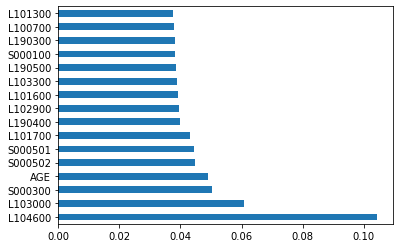

Index(['L104600', 'L103000', 'S000300', 'AGE', 'S000502', 'S000501', 'L101700',
       'L190400', 'L102900', 'L101600', 'L103300', 'L190500', 'S000100',
       'L190300', 'L100700', 'L101300', 'L103100', 'L100500', 'FIELD_38',
       'SEX'],
      dtype='object')


In [36]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(x,y)

print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers

#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=x.columns)
feat_importances.nlargest(16).plot(kind='barh')
plt.show()

print(feat_importances.nlargest(20).index)

3.2 SelectKBest method
=========

In [37]:
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest

bestfeatures = SelectKBest(score_func=f_classif, k=10)
fit = bestfeatures.fit(x,y)

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(x.columns)

featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns

# x=x[x.columns[:15]]
print(list(x.columns[:20]))

['L104600', 'L103000', 'S000300', 'S000501', 'S000502', 'L101700', 'L103300', 'SEX', 'L190400', 'AGE', 'L190500', 'L100700', 'L101300', 'L190300', 'L102900', 'L103100', 'L101600', 'L100500', 'S000100', 'FIELD_33']


3.3 variance inflation factor 
=============

In [24]:
# this function computes vif value which help us to remove columns with redundant information ( to avoid Multicollinearity)
# Multicollinearity occurs when two or more predictors in the model are correlated and provide redundant information about the response.
# Multicollinearity was measured by variance inflation factors (VIF) and tolerance

def vifcal(inputdata,depcol):
    vifL5=[]
    import statsmodels.formula.api as sm
    xvars=inputdata.drop([depcol],axis=1)
    xvarnames=xvars.columns
    for i in range(0,xvarnames.shape[0]):
        _y=xvars[xvarnames[i]]
        _x=xvars[xvarnames.drop(xvarnames[i])]
        rsq=sm.ols(formula="_y~_x",data=xvars).fit().rsquared
        vif=round(1/(1-rsq),2)
        print(i,', ',xvarnames[i]," VIF = ",vif)
        if(vif<5):
            vifL5.append(xvarnames[i])
    return vifL5

In [38]:
newcols = vifcal(mydata[['L104600', 'L103000', 'S000300', 'S000501', 'S000502', 'L101700', 'L103300', 'SEX',
                         'L190400', 'AGE', 'L190500', 'L100700', 'L101300', 'L190300', 'L102900', 'L103100', 
                         'L101600', 'L100500', 'S000100', 'FIELD_33','CLASS']],'CLASS')
print(newcols,len(newcols))

# we need to exclude features with vif value >5
# L190400  ,L103300,L190500,L190300,L102900,L103100  


0 ,  L104600  VIF =  1.19
1 ,  L103000  VIF =  1.87
2 ,  S000300  VIF =  1.62
3 ,  S000501  VIF =  2.78
4 ,  S000502  VIF =  2.55
5 ,  L101700  VIF =  1.44
6 ,  L103300  VIF =  13.96
7 ,  SEX  VIF =  5.35
8 ,  L190400  VIF =  17.54
9 ,  AGE  VIF =  1.38
10 ,  L190500  VIF =  21.99
11 ,  L100700  VIF =  2.01
12 ,  L101300  VIF =  1.3
13 ,  L190300  VIF =  5.04
14 ,  L102900  VIF =  5.79
15 ,  L103100  VIF =  9.14
16 ,  L101600  VIF =  1.21
17 ,  L100500  VIF =  2.12
18 ,  S000100  VIF =  2.56
19 ,  FIELD_33  VIF =  1.63
['L104600', 'L103000', 'S000300', 'S000501', 'S000502', 'L101700', 'AGE', 'L100700', 'L101300', 'L101600', 'L100500', 'S000100', 'FIELD_33'] 13


3.4 Final Selected Features
======

In [ ]:
# based on the out put of section of 3.1 and 3.3 the following features are selected

# L190400  ,L103300,L190500,L190300,L102900,L103100  

['L104600', 'L103000', 'S000300', 'S000501', 'S000502', 'L101700', 'L103300', 'SEX',  'AGE', 
 'L100700', 'L101300','L101600', 'L100500', 'S000100', 'FIELD_33']

======================================
========

In [ ]:
randomseed=7
# mydata=data[['L104600', 'L103000', 'S000300',  'L101700', 'SEX', 'AGE', #'S000501', 'S000502', 'L101300',
#              'L100700', 'FIELD_33', 'FIELD_38', 'FIELD_40', 'FIELD_31','CLASS']].copy().dropna()

mydata=data[['L104600', 'L103000', 'S000300', 'L101700', 'SEX', 'AGE', 'L100700', 'FIELD_33', 
             'FIELD_38', 'FIELD_40', 'FIELD_31','CLASS']].copy().dropna()

print(mydata.shape)
mydata.head()

In [ ]:
diabetic = mydata[mydata.CLASS==2]
prediabetic = mydata[mydata.CLASS==1]
normal = mydata[mydata.CLASS==0]

print(diabetic.shape[0],prediabetic.shape[0],normal.shape[0])

In [ ]:
diabetic_test = diabetic.sample(500,random_state=randomseed)
prediabetic_test = prediabetic.sample(500,random_state=randomseed)
normal_test = normal.sample(500,random_state=randomseed)
test=pd.concat([diabetic_test,prediabetic_test,normal_test])

diabetic_train = diabetic.drop(diabetic_test.index)
prediabetic_train = prediabetic.drop(prediabetic_test.index).sample(diabetic_train.shape[0],random_state=randomseed)
normal_train = normal.drop(normal_test.index).sample(diabetic_train.shape[0],random_state=randomseed)
train=pd.concat([diabetic_train,prediabetic_train,normal_train])

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(random_state=randomseed,n_estimators=100,max_depth=10 )
rf.fit(train.iloc[:,:-1],train.iloc[:,-1])

In [ ]:
ypred= rf.predict(test.iloc[:,:-1])

score=rf.score(test.iloc[:,:-1],test.iloc[:,-1])
print(score)

feat_importances = pd.Series(rf.feature_importances_, index=test.iloc[:,:-1].columns)
feat_importances.nlargest(16).plot(kind='barh')
plt.show()

print(feat_importances.nlargest(16).index)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test.iloc[:,-1],ypred)

In [ ]:
print("Accuracy on training set: {:.3f}".format(rf.score(train.iloc[:,:-1],train.iloc[:,-1])))
print("Accuracy on test set: {:.3f}".format(rf.score(test.iloc[:,:-1],test.iloc[:,-1] ))) 
ypred=rf.predict(test.iloc[:,:-1])

confmatrx=pd.DataFrame(confusion_matrix(test.iloc[:,-1],ypred))
confmatrx.head()


In [ ]:

from sklearn.metrics import classification_report 
print(classification_report(test.iloc[:,-1], ypred))


In [ ]:
import xgboost as xgb
from sklearn import metrics as m
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=randomseed)

xgb_model.fit(train.iloc[:,:-1],train.iloc[:,-1])

y_pred = xgb_model.predict((test.iloc[:,:-1]))

print('accuracy \t',m.accuracy_score(test.iloc[:,-1],y_pred))
confmatrx=pd.DataFrame(confusion_matrix(test.iloc[:,-1],y_pred))
confmatrx.head()

In [ ]:
print(classification_report(test.iloc[:,-1], y_pred))

===============================
==========

In [ ]:
newcols = vifcal(mydata,'CLASS')
print(newcols,len(newcols))

In [ ]:
corr=mydata.corr()
corr

In [ ]:
import seaborn as sns
sns.heatmap(corr,vmin=-1,vmax=1)